### Bayesian inference for poisson distribution

In [1]:
%matplotlib inline

import sys
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Poisson, Gamma, Empirical
from scipy.special import digamma, gammaln
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import clear_output

[ 1.  0.  1.  1.  3.  0.  0.  1.  0.  0.]


(array([ 45.,  35.,  15.,   4.,   1.,   0.,   0.,   0.,   0.,   0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

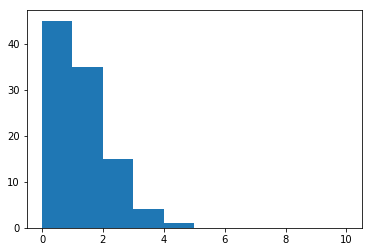

In [2]:
# Generate sample data
N = 100
lamb_true = 1.0
data = np.random.poisson(lam=lamb_true, size=N).astype('float32')
print data[:10]
plt.hist(data, bins=np.linspace(0, 10, 11))

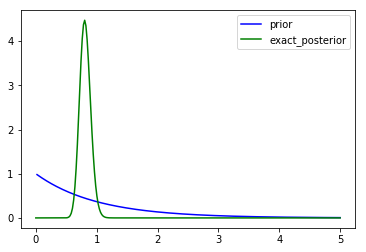

In [4]:
# Setup prior distribution for poisson parameter
alpha_0 = 1.0
beta_0 = 1.0
lamb = Gamma(concentration=tf.constant([alpha_0]), rate=tf.constant([beta_0]))

# Exact posterior is known: Gamma(alpha_0 + sum_i x_i, beta_0 + N)
# https://en.wikipedia.org/wiki/Poisson_distribution#Bayesian_inference
qlamb_exact = Gamma(concentration=tf.constant([alpha_0 + np.sum(data)]), rate=tf.constant(beta_0 + len(data)))

# Plot prior PDF and exact posterior PDF
xmesh = np.linspace(0, 5, 250, dtype=np.float32)

sess = ed.get_session()
lamb_values = sess.run(map(lamb.prob, xmesh))
qlamb_exact_values = sess.run(map(qlamb_exact.prob, xmesh))

line1, = plt.plot(xmesh, lamb_values, '-b', label='prior')
line2, = plt.plot(xmesh, qlamb_exact_values, '-g', label='exact_posterior')
plt.legend(handles=[line1, line2])

(-102.5, -100)

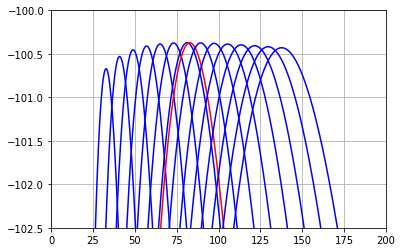

In [7]:
# Minimizing KLqp is equivalent to maximizing ELBO
# http://edwardlib.org/tutorials/klqp
# https://benmoran.wordpress.com/2015/02/21/variational-bayes-and-the-evidence-lower-bound/
# https://en.wikipedia.org/wiki/Gamma_distribution

def elbo(alpha, beta, alpha_0, beta_0, x):
    # Using poisson likelihood
    # Using gamma(alpha_0, beta_0) for prior
    # Using gamma(alpha, beta) for variational distribution
    # Using E[z], E[log(z)] and KL-divergence for gamma distribution 
    # Drop constants
    
    log_beta = np.log(beta)
    digamma_alpha = digamma(alpha)
    kl = (alpha - alpha_0) * digamma_alpha
    kl = kl - gammaln(alpha) + gammaln(alpha_0)
    kl = kl + alpha_0 * (log_beta - np.log(beta_0))
    kl = kl + alpha * (beta_0 - beta) / beta
    return - kl - len(x) * alpha / beta + (digamma_alpha - log_beta) * np.sum(x)

# Plot ELBO profiles 
def plot_elbo_alpha(alpha_bounds, npoints, beta, alpha_0, beta_0, x, fmt):
    alpha = np.linspace(alpha_bounds[0], alpha_bounds[1], npoints)
    elbo_values = map(lambda a: elbo(a, beta, alpha_0, beta_0, x), alpha)
    plt.plot(alpha, elbo_values, fmt)

plot_elbo_alpha([0.1, 200], npoints=500, beta=40, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=50, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=60, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=70, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=80, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=90, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=100, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=102, alpha_0=1, beta_0=1, x=data, fmt='-r')
plot_elbo_alpha([0.1, 200], npoints=500, beta=110, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=120, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=130, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=140, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=150, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=160, alpha_0=1, beta_0=1, x=data, fmt='-b')
plot_elbo_alpha([0.1, 200], npoints=500, beta=170, alpha_0=1, beta_0=1, x=data, fmt='-b')
plt.grid()
plt.xlim(0, 200)
plt.ylim(-102.5, -100)

In [8]:
# Maximize ELBO using numerical optimization
opt = minimize(
    fun=lambda x: -elbo(x[0], x[1], alpha_0, beta_0, data),
    method='l-bfgs-b',
    bounds=[(1e-4, None), (1.e-4, None)],
    x0=(1.0, 1.0)
)

print "Exact posterior parameters: alpha=%f, beta=%f" % (alpha_0 + np.sum(data), beta_0 + len(data))
print "Estimated posterior parameters: alpha=%f, beta=%f" % (opt.x[0], opt.x[1])

Exact posterior parameters: alpha=82.000000, beta=101.000000
Estimated posterior parameters: alpha=82.056576, beta=101.070205


In [ ]:
# Inference: 
x = Poisson(tf.ones(N) * lamb)
qlamb_alpha = tf.Variable([1.0])
qlamb_beta = tf.Variable([1.0])
qlamb = Gamma(concentration=qlamb_alpha, rate=qlamb_beta)

inference = ed.KLqp({lamb: qlamb}, data={x: data})
inference.initialize(n_iter=20000, n_samples=70)
tf.global_variables_initializer().run()

trace = np.zeros((inference.n_iter, 2))
for t in xrange(inference.n_iter):
    inference.update()
    trace[t,:] = sess.run([qlamb_alpha, qlamb_beta])
    if t % 500 == 0:
        print t, trace[t, 0], trace[t, 1]
        sys.stdout.flush()